In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import pandas as pd

data_file = "/Users/liuyuxuan/Downloads/calendar-spread-commodity/DATA.xlsx"

# Sheets with contango/backwardation: assume new format is like [Date, HG1, HG6]
backwardation_contango = [
    "backwardation_CL", "backwardation_CO", "backwardation_ZNA",
    "contango_HG", "contango_ALE", "contango_GC"
]

all_data = pd.DataFrame()

for sheet_name in backwardation_contango:
    product_name = sheet_name.split('_')[-1]  # Extract product suffix

    # Read data assuming format: [Date, X1, X6]
    data = pd.read_excel(data_file, sheet_name=sheet_name, usecols=[0, 1, 2])
    data.columns = ['Date', f'{product_name}_1', f'{product_name}_6']

    # Clean and process
    data['Date'] = pd.to_datetime(data['Date'])
    data = data.dropna().sort_values(by='Date')
    data[f'{product_name}_Spread'] = data[f'{product_name}_1'] - data[f'{product_name}_6']

    # Merge
    if all_data.empty:
        all_data = data
    else:
        all_data = pd.merge(all_data, data, on='Date', how='outer')
seasonal_products = ["seasonal_NG", "seasonal_HO", "seasonal_XB"]

for sheet_name in seasonal_products:
    product_name = sheet_name.split('_')[-1]

    data = pd.read_excel(data_file, sheet_name=sheet_name, usecols=[0, 1, 2])
    data.columns = ['Date', f'{product_name}_1', f'{product_name}_6']

    data['Date'] = pd.to_datetime(data['Date'])
    data = data.dropna().sort_values(by='Date')
    data[f'{product_name}_Spread'] = data[f'{product_name}_1'] - data[f'{product_name}_6']
    data['Year'] = data['Date'].dt.year

    yearly_means = data.groupby('Year')[f'{product_name}_Spread'].mean().reset_index()
    data = pd.merge(data, yearly_means, on='Year', suffixes=('', '_YearlyMean'))

    all_data = pd.merge(all_data, data[['Date', f'{product_name}_1', f'{product_name}_6', f'{product_name}_Spread']],
                        on='Date', how='outer')


## Method2

In [3]:
all_data.head()

,Date,CL_1,CL_6,CL_Spread,CO_1,CO_6,CO_Spread,ZNA_1,ZNA_6,ZNA_Spread,...,GC_Spread,NG_1,NG_6,NG_Spread,HO_1,HO_6,HO_Spread,XB_1,XB_6,XB_Spread
0,2014-01-02,95.44,93.95,1.49,107.78,106.44,1.34,2505.78512,2531.40496,-25.61984,...,-3.4,4.321,4.468,-0.147,2.9867,2.9044,0.0823,2.6950,2.5264,0.1686
1,2014-01-03,93.96,92.61,1.35,106.89,105.18,1.71,2492.10887,2513.59257,-21.48370,...,-3.6,4.304,4.456,-0.152,2.9394,2.8673,0.0721,2.6488,2.4956,0.1532
2,2014-01-06,93.43,92.26,1.17,106.73,105.32,1.41,2479.80974,2488.89329,-9.08355,...,-3.5,4.306,4.470,-0.164,2.9388,2.8749,0.0639,2.6460,2.5018,0.1442
3,2014-01-07,93.67,92.16,1.51,107.35,105.73,1.62,2483.59965,2491.86179,-8.26214,...,-3.4,4.299,4.434,-0.135,2.9593,2.8755,0.0838,2.6786,2.5143,0.1643
4,2014-01-08,92.33,91.07,1.26,107.15,105.43,1.72,2486.11937,2494.38165,-8.26228,...,-3.3,4.216,4.345,-0.129,2.9494,2.8722,0.0772,2.6563,2.5009,0.1554


Drop all NA values

In [4]:
all_data_common = all_data.dropna(how='any').copy()
print(f"Data after dropping incomplete rows: {all_data_common.shape}")

Data after dropping incomplete rows: (2498, 28)


For commodities in backwardation or contango, we use the rolling window of 252 days to compute the mean and variance.

normalize rolling

In [5]:
rolling_window = 252

# Process data in all_data_common for backwardation and contango products
for sheet_name in backwardation_contango:
    # Extract product name, e.g., backwardation_CL -> CL
    product_name = sheet_name.split('_')[-1]
    spread_column = f"{product_name}_Spread"

    # Ensure the Spread column exists in the main DataFrame
    if spread_column not in all_data_common.columns:
        print(f"{spread_column} not found in all_data_common. Skipping...")
        continue

    # Filter data for the current product and sort by date
    data = all_data_common[['Date', spread_column]].copy()
    data = data.sort_values(by='Date')

    # Compute rolling mean and standard deviation for normalization (look-back only)
    data['Rolling_Spread_Mean'] = data[spread_column].rolling(window=rolling_window, min_periods=1).mean()
    data['Rolling_Spread_Std'] = data[spread_column].rolling(window=rolling_window, min_periods=1).std()

    # Calculate normalized Spread values using rolling mean and std
    data['Normalized_Spread'] = (data[spread_column] - data['Rolling_Spread_Mean']) / data['Rolling_Spread_Std']

    # Compute rolling mean and variance on the normalized Spread
    data['Rolling_Mean'] = data['Normalized_Spread'].rolling(window=rolling_window, min_periods=1).mean()
    data['Rolling_Var'] = data['Normalized_Spread'].rolling(window=rolling_window, min_periods=1).var()

    # Define dynamic thresholds for trading logic
    data['Up'] = data['Rolling_Mean'] + 0.25 * data['Rolling_Var']
    data['Down'] = data['Rolling_Mean'] - 0.25 * data['Rolling_Var']
    data['Up_Stop'] = data['Rolling_Mean'] + 3 * data['Rolling_Var']
    data['Down_Stop'] = data['Rolling_Mean'] - 3 * data['Rolling_Var']

    data = data[data['Date'] >= '2023-01-01'].reset_index(drop=True)

    # Initialize weights for positions (zero at start)
    start_index = 0
    data[f'W_{product_name}_1'] = None  # Closer maturity
    data[f'W_{product_name}_6'] = None  # Farther maturity
    data.loc[start_index, f'W_{product_name}_1'] = 0
    data.loc[start_index, f'W_{product_name}_6'] = 0

    # Trading logic: Update weights based on previous day's data
    for i in range(1, len(data)):
        prev_row = data.iloc[i - 1]  # Previous day's data
        position1 = prev_row[f'W_{product_name}_1']
        position2 = prev_row[f'W_{product_name}_6']

        if position1 == 0 and position2 == 0:  # No current position
            if prev_row['Normalized_Spread'] > prev_row['Up']:
                position1 = 1
                position2 = -1
            elif prev_row['Normalized_Spread'] < prev_row['Down']:
                position1 = -1
                position2 = 1
        elif position1 > 0:  # Holding long position
            if prev_row['Normalized_Spread'] <= prev_row['Rolling_Mean'] or \
               prev_row['Normalized_Spread'] > prev_row['Up_Stop']:
                position1 = 0
                position2 = 0
        elif position1 < 0:  # Holding short position
            if prev_row['Normalized_Spread'] >= prev_row['Rolling_Mean'] or \
               prev_row['Normalized_Spread'] < prev_row['Down_Stop']:
                position1 = 0
                position2 = 0

        # Update today's weights
        data.loc[i, f'W_{product_name}_1'] = position1
        data.loc[i, f'W_{product_name}_6'] = position2

    # Merge the updated weights back into the main DataFrame
    all_data_common = all_data_common.merge(
        data[['Date', f'W_{product_name}_1', f'W_{product_name}_6']],
        on='Date', how='left'
    )

# Filter data starting from 2015-01-01 in the main DataFrame
all_data_common = all_data_common[all_data_common['Date'] >= '2023-01-01'].reset_index(drop=True)

# Display the final result
print("Final all_data_common starting from 2023-01-01:")
print(all_data_common.head())

Final all_data_common starting from 2023-01-01:
        Date   CL_1   CL_6  CL_Spread   CO_1   CO_6  CO_Spread       ZNA_1   
0 2023-01-03  76.93  76.99      -0.06  82.10  83.63      -1.53  3400.43093  \
1 2023-01-04  72.84  73.48      -0.64  77.84  80.78      -2.94  3401.40498   
2 2023-01-05  73.67  74.25      -0.58  78.69  77.39       1.30  3378.96756   
3 2023-01-06  73.77  74.43      -0.66  78.57  78.15       0.42  3413.86632   
4 2023-01-09  74.63  75.45      -0.82  79.65  78.17       1.48  3471.16592   

        ZNA_6  ZNA_Spread  ...  W_CO_1  W_CO_6  W_ZNA_1  W_ZNA_6  W_HG_1   
0  3354.87976    45.55117  ...       0       0        0        0       0  \
1  3350.60524    50.79974  ...      -1       1       -1        1      -1   
2  3320.83479    58.13277  ...      -1       1       -1        1      -1   
3  3365.54653    48.31979  ...      -1       1       -1        1       0   
4  3410.61803    60.54789  ...      -1       1       -1        1       0   

   W_HG_6  W_ALE_1  W_ALE_

For commodities with sensonal trends, we use yearly mean and vairance

In [6]:
for sheet_name in seasonal_products:
    # Extract product name, e.g., seasonal_NG -> NG
    product_name = sheet_name.split('_')[-1]
    spread_column = f"{product_name}_Spread"

    # Ensure the Spread column exists in all_data_common
    if spread_column not in all_data_common.columns:
        print(f"{spread_column} not found in all_data_common. Skipping...")
        continue

    # Filter data for the current product
    data = all_data_common[['Date', spread_column]].copy()
    data = data.dropna().sort_values(by='Date')

    # Extract year from date
    data['Year'] = data['Date'].dt.year

    # Compute yearly mean and variance
    yearly_stats = data.groupby('Year')[spread_column].agg(['mean', 'var']).reset_index()
    yearly_stats.rename(columns={'mean': 'Yearly_Mean', 'var': 'Yearly_Var'}, inplace=True)

    # Merge yearly statistics back into data
    data = data.merge(yearly_stats, on='Year', how='left')

    # Define thresholds dynamically using yearly statistics
    data['Up'] = data['Yearly_Mean'] + 0.25 * data['Yearly_Var']
    data['Down'] = data['Yearly_Mean'] - 0.25 * data['Yearly_Var']
    data['Up_Stop'] = data['Yearly_Mean'] + 3 * data['Yearly_Var']
    data['Down_Stop'] = data['Yearly_Mean'] - 3 * data['Yearly_Var']

    # Initialize weight columns and set the first row to zero
    data[f'W_{product_name}_1'] = None
    data[f'W_{product_name}_6'] = None
    data.loc[0, f'W_{product_name}_1'] = 0
    data.loc[0, f'W_{product_name}_6'] = 0

    # Trading logic: starting from the second row, update weights based on the previous day's data
    for i in range(1, len(data)):
        prev_row = data.iloc[i - 1]  # Get the previous day's data
        position1 = prev_row[f'W_{product_name}_1']
        position2 = prev_row[f'W_{product_name}_6']

        # Entry logic when there is no position
        if position1 == 0 and position2 == 0:
            if prev_row[spread_column] > prev_row['Up']:
                position1 = 1  # Buy near month
                position2 = -1  # Sell far month
            elif prev_row[spread_column] < prev_row['Down']:
                position1 = -1  # Sell near month
                position2 = 1  # Buy far month

        # Exit logic when holding a position
        elif position1 > 0:  # Holding a long position
            if prev_row[spread_column] <= prev_row['Yearly_Mean'] or \
               prev_row[spread_column] > prev_row['Up_Stop']:
                position1 = 0
                position2 = 0
        elif position1 < 0:  # Holding a short position
            if prev_row[spread_column] >= prev_row['Yearly_Mean'] or \
               prev_row[spread_column] < prev_row['Down_Stop']:
                position1 = 0
                position2 = 0

        # Update today's weights
        data.loc[i, f'W_{product_name}_1'] = position1
        data.loc[i, f'W_{product_name}_6'] = position2

    # Merge the results back into all_data_common
    all_data_common = all_data_common.merge(
        data[['Date', f'W_{product_name}_1', f'W_{product_name}_6']],
        on='Date', how='left'
    )

    # Output the results
    print(f"Seasonality thresholds and weights for {product_name}:")
    print(data[['Date', spread_column, 'Yearly_Mean', 'Up', 'Down', 'Up_Stop', 'Down_Stop',
                f'W_{product_name}_1', f'W_{product_name}_6']].head(10))
    print("-" * 50)

# Check the final result in all_data_common
print("Final all_data_common with seasonality weights:")
print(all_data_common.head())

Seasonality thresholds and weights for NG:
        Date  NG_Spread  Yearly_Mean        Up      Down   Up_Stop  Down_Stop   
0 2023-01-03     -0.966    -0.875863 -0.848793 -0.902932 -0.551028  -1.200697  \
1 2023-01-04     -0.846    -0.875863 -0.848793 -0.902932 -0.551028  -1.200697   
2 2023-01-05     -1.074    -0.875863 -0.848793 -0.902932 -0.551028  -1.200697   
3 2023-01-06     -1.049    -0.875863 -0.848793 -0.902932 -0.551028  -1.200697   
4 2023-01-09     -0.966    -0.875863 -0.848793 -0.902932 -0.551028  -1.200697   
5 2023-01-10     -1.065    -0.875863 -0.848793 -0.902932 -0.551028  -1.200697   
6 2023-01-11     -1.069    -0.875863 -0.848793 -0.902932 -0.551028  -1.200697   
7 2023-01-12     -1.062    -0.875863 -0.848793 -0.902932 -0.551028  -1.200697   
8 2023-01-13     -1.243    -0.875863 -0.848793 -0.902932 -0.551028  -1.200697   
9 2023-01-17     -1.084    -0.875863 -0.848793 -0.902932 -0.551028  -1.200697   

  W_NG_1 W_NG_6  
0      0      0  
1     -1      1  
2      0   

To keep consistent, after computing the position using the method of paper, we combine all data and position into one dataframe. Our backtest time frame is from 2023 to 2024 (2 years).

In [7]:
print("Final all_data_common with seasonality weights:")
print(all_data_common.head())

Final all_data_common with seasonality weights:
        Date   CL_1   CL_6  CL_Spread   CO_1   CO_6  CO_Spread       ZNA_1   
0 2023-01-03  76.93  76.99      -0.06  82.10  83.63      -1.53  3400.43093  \
1 2023-01-04  72.84  73.48      -0.64  77.84  80.78      -2.94  3401.40498   
2 2023-01-05  73.67  74.25      -0.58  78.69  77.39       1.30  3378.96756   
3 2023-01-06  73.77  74.43      -0.66  78.57  78.15       0.42  3413.86632   
4 2023-01-09  74.63  75.45      -0.82  79.65  78.17       1.48  3471.16592   

        ZNA_6  ZNA_Spread  ...  W_ALE_1  W_ALE_6  W_GC_1  W_GC_6  W_NG_1   
0  3354.87976    45.55117  ...        0        0       0       0       0  \
1  3350.60524    50.79974  ...        1       -1       1      -1      -1   
2  3320.83479    58.13277  ...        0        0       1      -1       0   
3  3365.54653    48.31979  ...        0        0       1      -1      -1   
4  3410.61803    60.54789  ...       -1        1       1      -1      -1   

   W_NG_6  W_HO_1  W_HO_6 

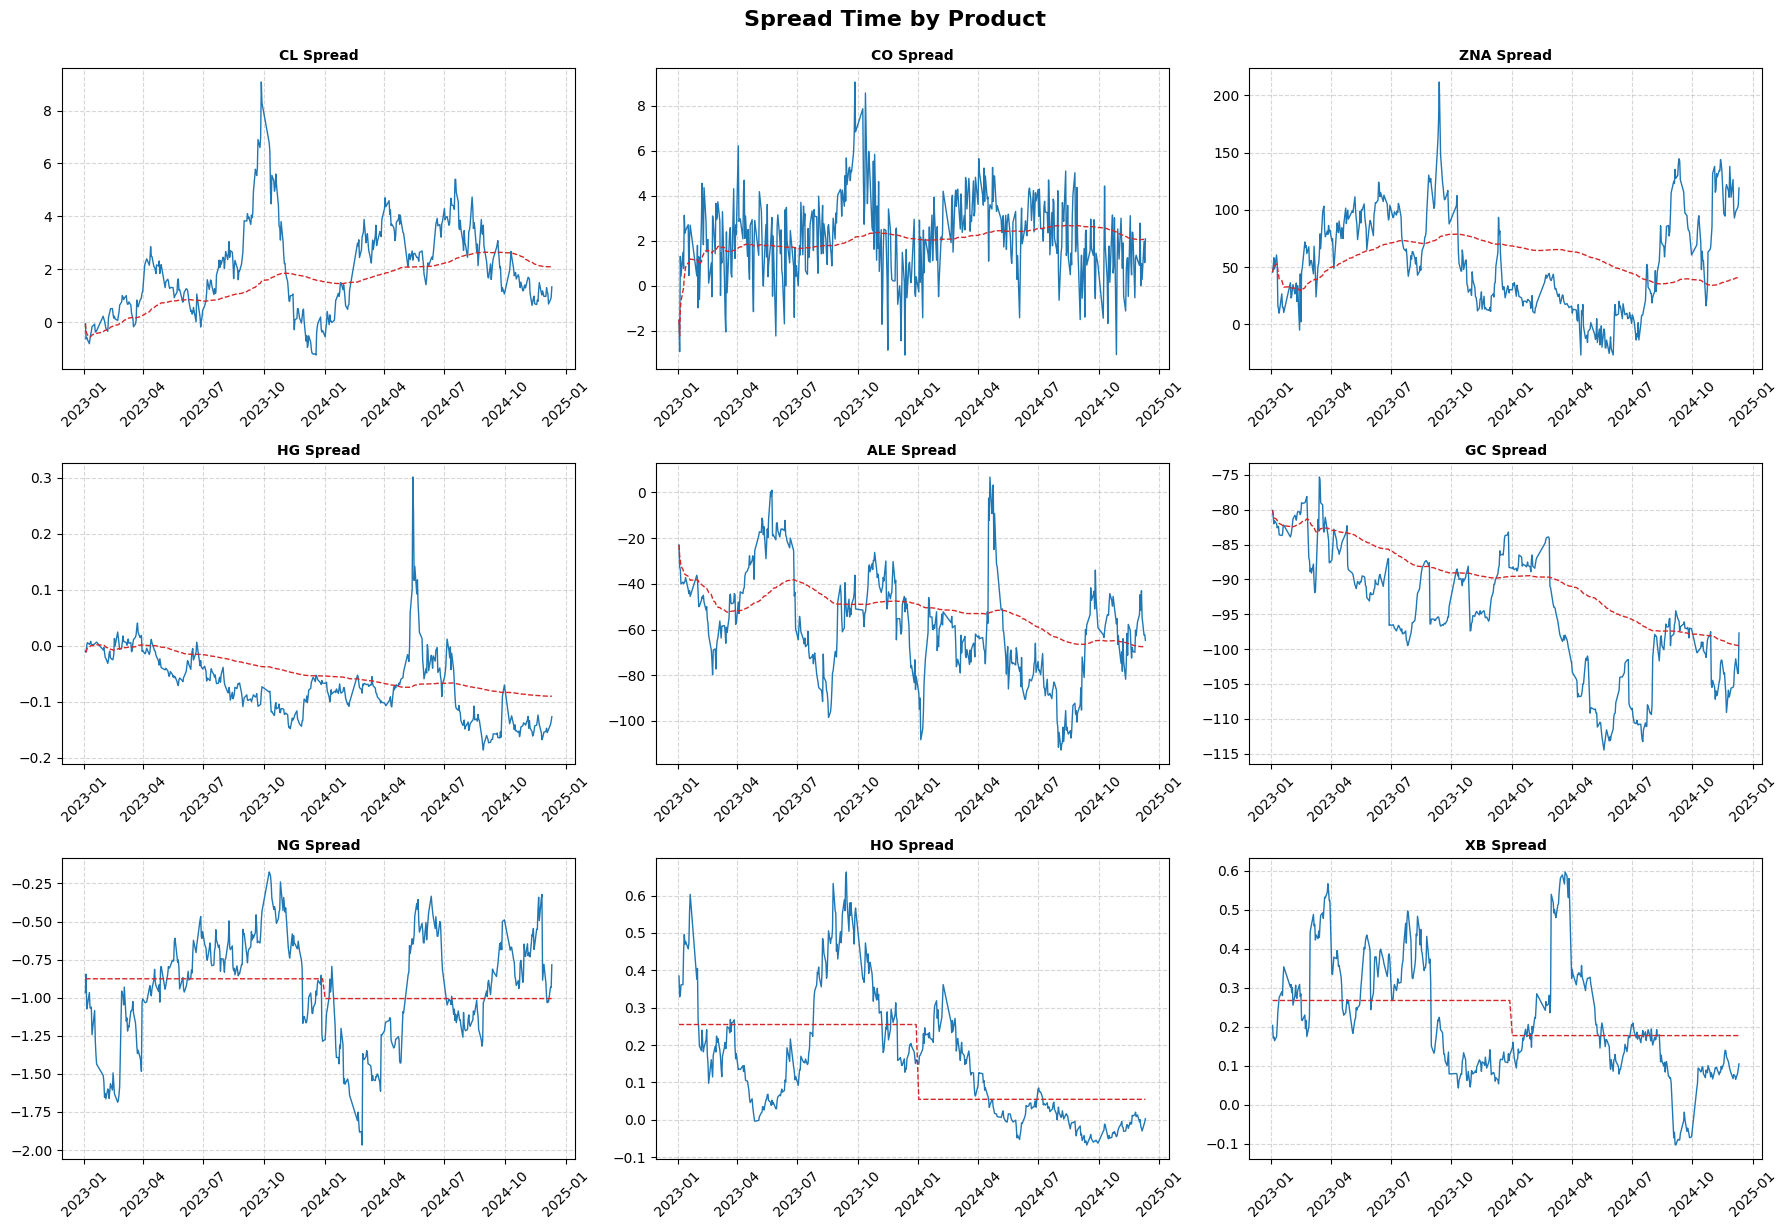

In [8]:
import matplotlib.dates as mdates

# Plots
rolling_window = 252
backwardation_contango = ['backwardation_CL', 'backwardation_CO', 'backwardation_ZNA',
                          'backwardation_HG', 'backwardation_ALE', 'backwardation_GC']
seasonal_products = ['seasonal_NG', 'seasonal_HO', 'seasonal_XB']

# Function to plot spreads with clean formatting
def plot_spread(ax, data, spread_column, mean_type, product_name):
    """
    Plots the spread and mean on the given subplot axis.
    """
    ax.plot(data['Date'], data[spread_column], label="Spread", color='tab:blue', linewidth=1)

    # Add mean line based on type
    if mean_type == 'rolling':
        rolling_mean = data[spread_column].rolling(window=rolling_window, min_periods=1).mean()
        ax.plot(data['Date'], rolling_mean, label='Rolling Mean (252)', color='tab:red', linestyle='--', linewidth=1)
    elif mean_type == 'yearly':
        ax.plot(data['Date'], data['Yearly_Mean'], label='Yearly Mean', color='tab:red', linestyle='--', linewidth=1)

    # Set title and style
    ax.set_title(f"{product_name} Spread", fontsize=10, fontweight='bold')
    ax.grid(visible=True, linestyle='--', alpha=0.5)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.tick_params(axis='x', rotation=45)

# Set up 3x3 subplots
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()

# Plot backwardation/contango products FIRST
for idx, sheet_name in enumerate(backwardation_contango):
    product_name = sheet_name.split('_')[-1]
    spread_column = f"{product_name}_Spread"

    if spread_column in all_data_common.columns:
        data = all_data_common[['Date', spread_column]].dropna()
        plot_spread(axes[idx], data, spread_column, mean_type='rolling', product_name=product_name)

# Plot seasonal products SECOND
for idx, sheet_name in enumerate(seasonal_products, start=len(backwardation_contango)):
    product_name = sheet_name.split('_')[-1]
    spread_column = f"{product_name}_Spread"

    if spread_column in all_data_common.columns:
        # Process data and compute yearly mean
        data = all_data_common[['Date', spread_column]].dropna()
        data['Year'] = pd.to_datetime(data['Date']).dt.year
        yearly_mean = data.groupby('Year')[spread_column].mean().reset_index()
        yearly_mean.rename(columns={spread_column: 'Yearly_Mean'}, inplace=True)
        data = data.merge(yearly_mean, on='Year', how='left')

        plot_spread(axes[idx], data, spread_column, mean_type='yearly', product_name=product_name)

plt.tight_layout()
plt.suptitle("Spread Time by Product", fontsize=16, y=1.02, fontweight='bold')
plt.show()

**PnL**

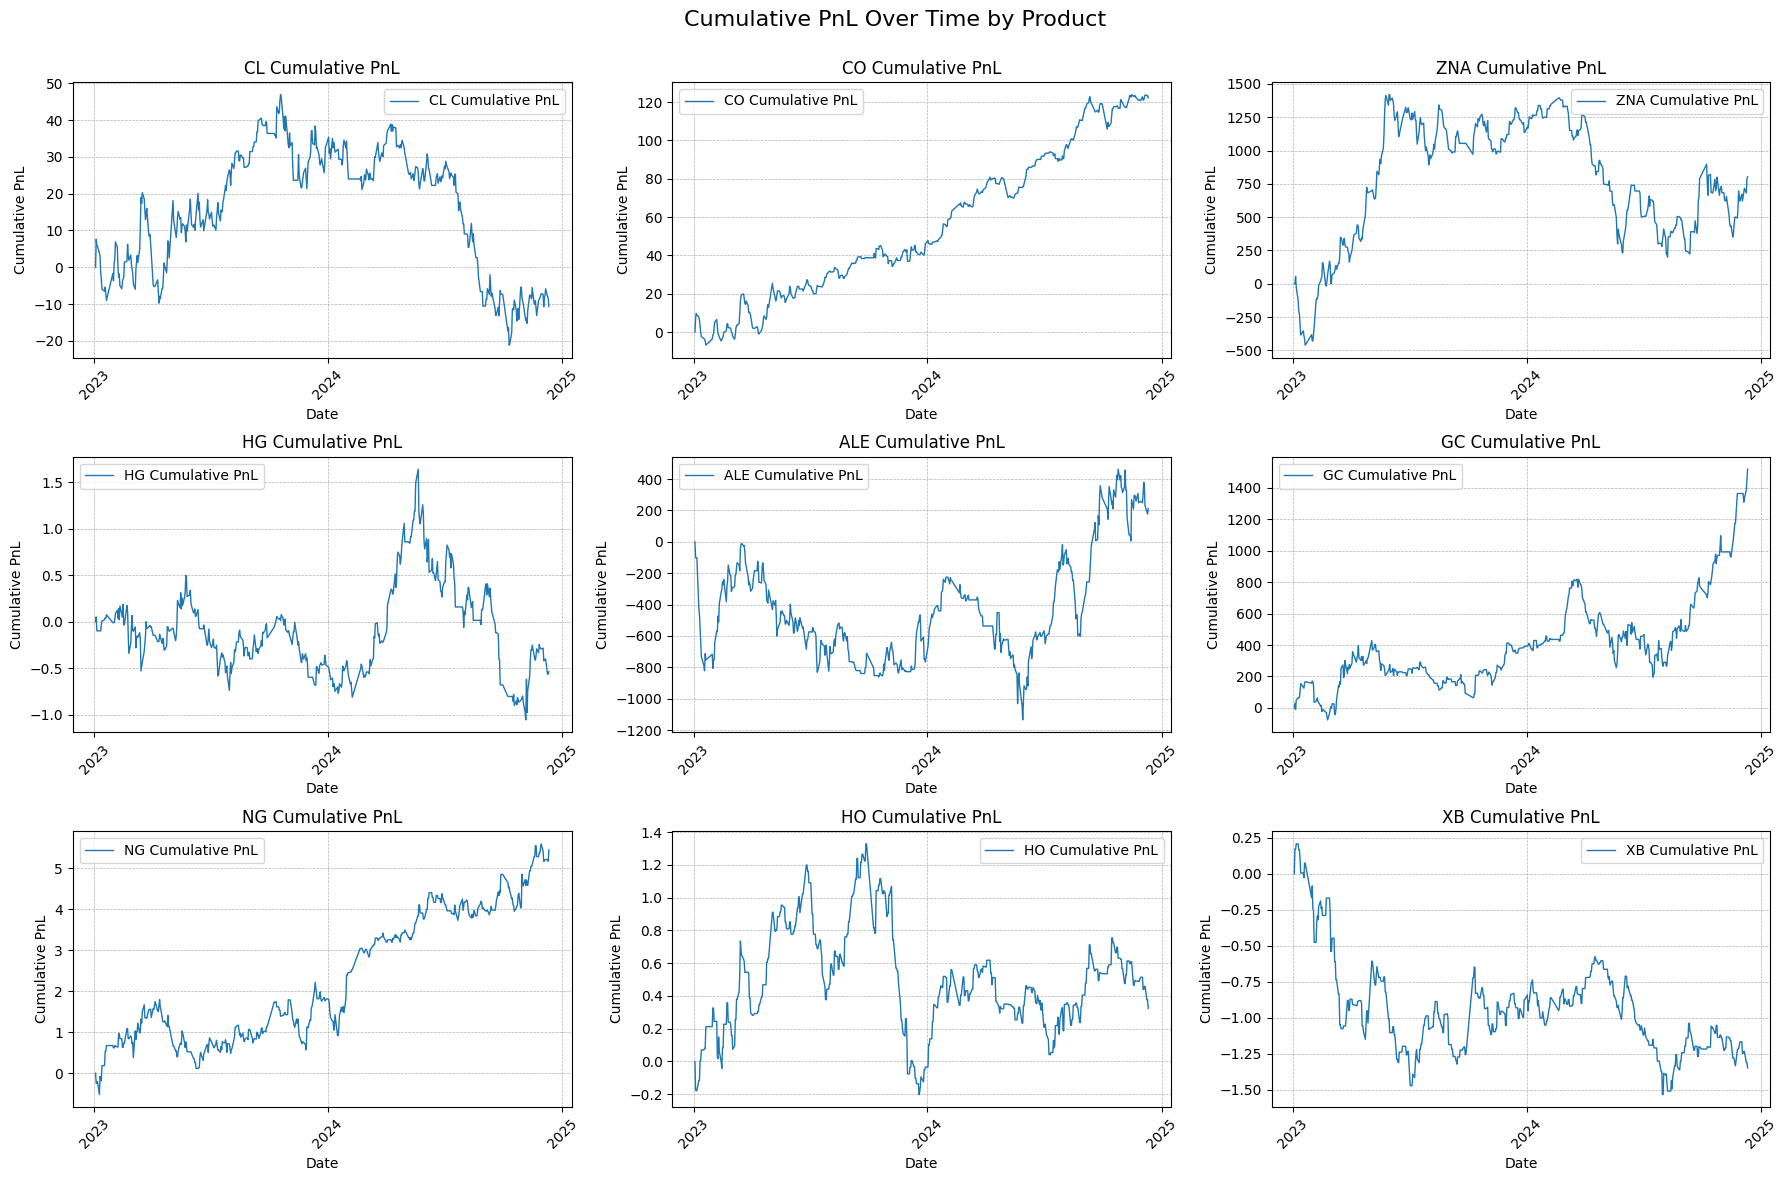

In [9]:
products = [sheet.split('_')[-1] for sheet in backwardation_contango + seasonal_products]

for product in products:
    # Calculate daily changes for near (1) and far (6) maturities
    all_data_common[f"{product}_1_Change"] = all_data_common[f"{product}_1"].diff(1)
    all_data_common[f"{product}_6_Change"] = all_data_common[f"{product}_6"].diff(1)

    # Calculate daily PnL
    all_data_common[f"{product}_Daily_PnL"] = (
        all_data_common[f"W_{product}_1"] * all_data_common[f"{product}_1_Change"]
        - all_data_common[f"W_{product}_6"] * all_data_common[f"{product}_6_Change"]
    )

    # Handle the first value for PnL
    all_data_common.loc[0, f"{product}_Daily_PnL"] = 0  # No PnL on the first day

    # Calculate cumulative PnL
    all_data_common[f"{product}_Cumulative_PnL"] = all_data_common[f"{product}_Daily_PnL"].cumsum()

# Plotting
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))
fig.suptitle("Cumulative PnL Over Time by Product", fontsize=16)
axes = axes.flatten()

for i, product in enumerate(products):
    axes[i].plot(
        all_data_common["Date"],
        all_data_common[f"{product}_Cumulative_PnL"],
        label=f"{product} Cumulative PnL",
        color="tab:blue",
        linewidth=1
    )
    axes[i].set_title(f"{product} Cumulative PnL")
    axes[i].set_xlabel("Date")
    axes[i].set_ylabel("Cumulative PnL")
    axes[i].xaxis.set_major_locator(mdates.YearLocator())
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(visible=True, which='major', linestyle='--', linewidth=0.5)
    axes[i].legend()

for j in range(len(products), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

In [10]:
# return
initial_capital = 10000

# Calculate and display the final return for each product
for product in products:
    # Calculate the final cumulative PnL
    final_pnl = all_data_common[f"{product}_Cumulative_PnL"].iloc[-1]

    # Calculate total return as a percentage
    final_return = (final_pnl / initial_capital) * 100

    # Print final return
    print(f"Final Return for {product}: {final_return:.6f}%")

Final Return for CL: -0.106600%
Final Return for CO: 1.221700%
Final Return for ZNA: 8.026980%
Final Return for HG: -0.005385%
Final Return for ALE: 2.125000%
Final Return for GC: 15.192000%
Final Return for NG: 0.054460%
Final Return for HO: 0.003240%
Final Return for XB: -0.013495%
